# NN Model IV
- Include Weather And Time Embedding
- Include Pokemon Type Embedding

In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as layers
from tensorflow.keras.utils import plot_model

import sys
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(42)
tf.random.set_seed(42)

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline, Pipeline


### Loading Data

In [3]:
def load(file_name, delimiter='|'):
    relative_path = '../data/'
    return pd.read_csv(relative_path+file_name, delimiter=delimiter)

Submission = load('01_raw/Submission.csv')
AvailablePokemons = load('01_raw/AvailablePokemons.csv')
BattleResults = load('01_raw/Battle_Results.csv')
Weakness_Pokemon = load('01_raw/Weakness_Pokemon.csv')
AllPokemons = load('01_raw/All_Pokemons.csv')

In [4]:
BattleResults.head()

,Name_1,Level_1,Price_1,HP_1,Attack_1,Defense_1,Sp_Atk_1,Sp_Def_1,Speed_1,Legendary_1,...,Price_2,HP_2,Attack_2,Defense_2,Sp_Atk_2,Sp_Def_2,Speed_2,Legendary_2,WeatherAndTime,BattleResult
0,Metapod,30,441,150,36,103,47,47,58,False,...,1589,262,393,306,164,211,253,False,Windy,-262
1,Pinsir,36,1227,196,304,237,129,164,197,False,...,1583,547,127,365,172,172,200,False,Unknown,-424
2,Metapod,15,297,92,26,73,33,33,40,False,...,4913,821,1208,947,504,652,781,False,Windy,-821
3,Pinsir,40,1401,228,346,270,146,187,224,False,...,588,202,47,138,63,63,75,False,Unknown,214
4,Pinsir,12,634,91,157,124,70,86,106,False,...,381,126,32,90,41,41,51,False,Windy,41


### Data Pipeline Auxilliary Functions

In [5]:
def RelativeResult(X):
    HP = X.apply(lambda row: row["HP_1"] if row["BattleResult"] > 0 else row["HP_2"], axis=1).values
    relativized = X["BattleResult"].values / HP
    return relativized

y = RelativeResult(BattleResults)

In [6]:
class LevelScaler(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        pass
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        return X / 99

In [31]:
class AddPokemonTypes(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        self.type_attributes = ['Type1_1', 'Type2_1', 'Type1_2', 'Type2_2'] # Where Type2_1 is the second type of the first pokemon
        self.NametoIndex = {sys.intern(name): AllPokemons.loc[AllPokemons["Name"]==name].iloc[0].ID-1 for name in AllPokemons.Name}
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, df):
        # Values for faster processing
        df = df.copy()
        values = df.values
        AllPokemonTypes = AllPokemons.loc[:,['Type_1', 'Type_2']]
        AllPokemonTypes.Type_2 = AllPokemons.Type_2.fillna(AllPokemons.Type_1)
        AllPokemonTypes = AllPokemonTypes.values
        
        # Old Column indexes
        name1_idx = df.columns.get_loc("Name_1")
        name2_idx = df.columns.get_loc("Name_2")

        # New Columns
        Types = np.empty((len(df),4), dtype='U15')

        for i in range(len(df)):
            idx_1 = self.NametoIndex[values[i,name1_idx]]
            idx_2 = self.NametoIndex[values[i,name2_idx]]

            # Types
            Types[i, 0] = AllPokemonTypes[idx_1, 0]
            Types[i, 1] = AllPokemonTypes[idx_1, 1]
            Types[i, 2] = AllPokemonTypes[idx_2, 0]
            Types[i, 3] = AllPokemonTypes[idx_2, 1]

        
        # Add columns
        df[self.type_attributes] = pd.DataFrame(Types, index=df.index)
        return df

In [8]:
def DuplicateData(df, y):
    df_inverse = df.copy()
    y_inverse = y.copy()
    
    # Inverse y
    y_inverse = (-1) * y_inverse
    
    # Inverse df
    swap_attributes = ['Name', 'Level', 'HP', 'Attack', 'Defense', 'Sp_Atk', 'Speed', 'Legendary', 'Price']
    for attr in swap_attributes:
        df_inverse.loc[:, [f'{attr}_1', f'{attr}_2']] = df.loc[:, [f'{attr}_2', f'{attr}_1']].values
    df_inverse.loc[:, 'BattleResult'] = - df.loc[:, 'BattleResult'] # just for consistency
    
    # Merge and Shuffle
    df_duplicated = df.append(df_inverse)
    y_duplicated = np.concatenate([y, y_inverse], axis=0)
    #df_duplicated, y_duplicated = sklearn.utils.shuffle(df_duplicated, y_duplicated, random_state=42)
    
    return df_duplicated, y_duplicated

### Data Pipeline Transformation

In [9]:
BattleResults_train, BattleResults_val, y_train, y_val  = train_test_split(BattleResults, y, test_size=0.2, random_state=42)

In [29]:
BattleResults_train_augm, y_train_augm = DuplicateData(BattleResults_train, y_train)

In [32]:
#%%capture
numerical_attributes = ['HP_1', 'Attack_1', 'Defense_1', 'Sp_Atk_1', 'Sp_Def_1', 'Speed_1', 
                          'HP_2', 'Attack_2', 'Defense_2', 'Sp_Atk_2', 'Sp_Def_2', 'Speed_2']
type_attributes = ['Type1_1', 'Type2_1', 'Type1_2', 'Type2_2']
TypeEncoder = OrdinalEncoder()

full_pipeline = Pipeline([
    ("Add Types", AddPokemonTypes()),
    ("Individual Feature Preprocessing", ColumnTransformer([
        ("Drop", "drop", ['Name_1', 'Name_2', 'Price_1', 'Price_2', 'BattleResult']),
        ("Numerical Attributes", StandardScaler(), numerical_attributes), # Faulty when not using augmented data
        ("Boolean", "passthrough", ['Legendary_1', 'Legendary_2']),
        ("Level" , LevelScaler(), ['Level_1', 'Level_2']),
        ("Weather", OrdinalEncoder(), ['WeatherAndTime']),
        ("Types", TypeEncoder, type_attributes)
    ])),
])
full_pipeline.fit(BattleResults_train_augm); #battle_data

In [33]:
BattleResults_train_augm

,Name_1,Level_1,Price_1,HP_1,Attack_1,Defense_1,Sp_Atk_1,Sp_Def_1,Speed_1,Legendary_1,...,Price_2,HP_2,Attack_2,Defense_2,Sp_Atk_2,Sp_Def_2,Speed_2,Legendary_2,WeatherAndTime,BattleResult
445914,Clefable,37,1273,263,182,192,246,236,154,False,...,2141,307,354,282,282,282,634,False,Unknown,-264
2117837,Omastar,32,1099,175,133,271,247,156,117,False,...,1583,340,241,258,316,285,143,False,Night,-340
2533271,Kingler,60,1953,277,518,458,201,201,298,False,...,355,47,72,54,49,66,67,False,Rain,277
815958,Gastly,27,643,104,66,56,197,66,154,False,...,1163,240,166,176,225,215,141,False,Sunshine,-175
1145299,Sandshrew,55,1214,237,292,337,76,116,156,False,...,4173,726,606,733,883,806,419,False,Unknown,-698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,Pidgeot,93,5036,920,835,779,726,88,1050,False,...,488,86,116,88,72,726,38,False,Windy,920
1692743,Dragonite,73,3605,593,801,559,593,120,466,False,...,832,129,147,198,140,593,98,False,Night,593
2356330,Arcanine,53,2303,399,445,335,403,1433,386,False,...,6309,1049,850,773,991,335,1213,False,Unknown,-1049
2229084,Venomoth,64,2108,365,294,272,418,132,418,False,...,1351,205,188,282,282,341,262,False,Windy,255


In [12]:
#%%capture
x_train_augm = full_pipeline.transform(BattleResults_train_augm)
x_val = full_pipeline.transform(BattleResults_val)

/home/joel/.local/share/virtualenvs/pokethon-gj-dbL-j/lib/python3.6/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


### Functional Model

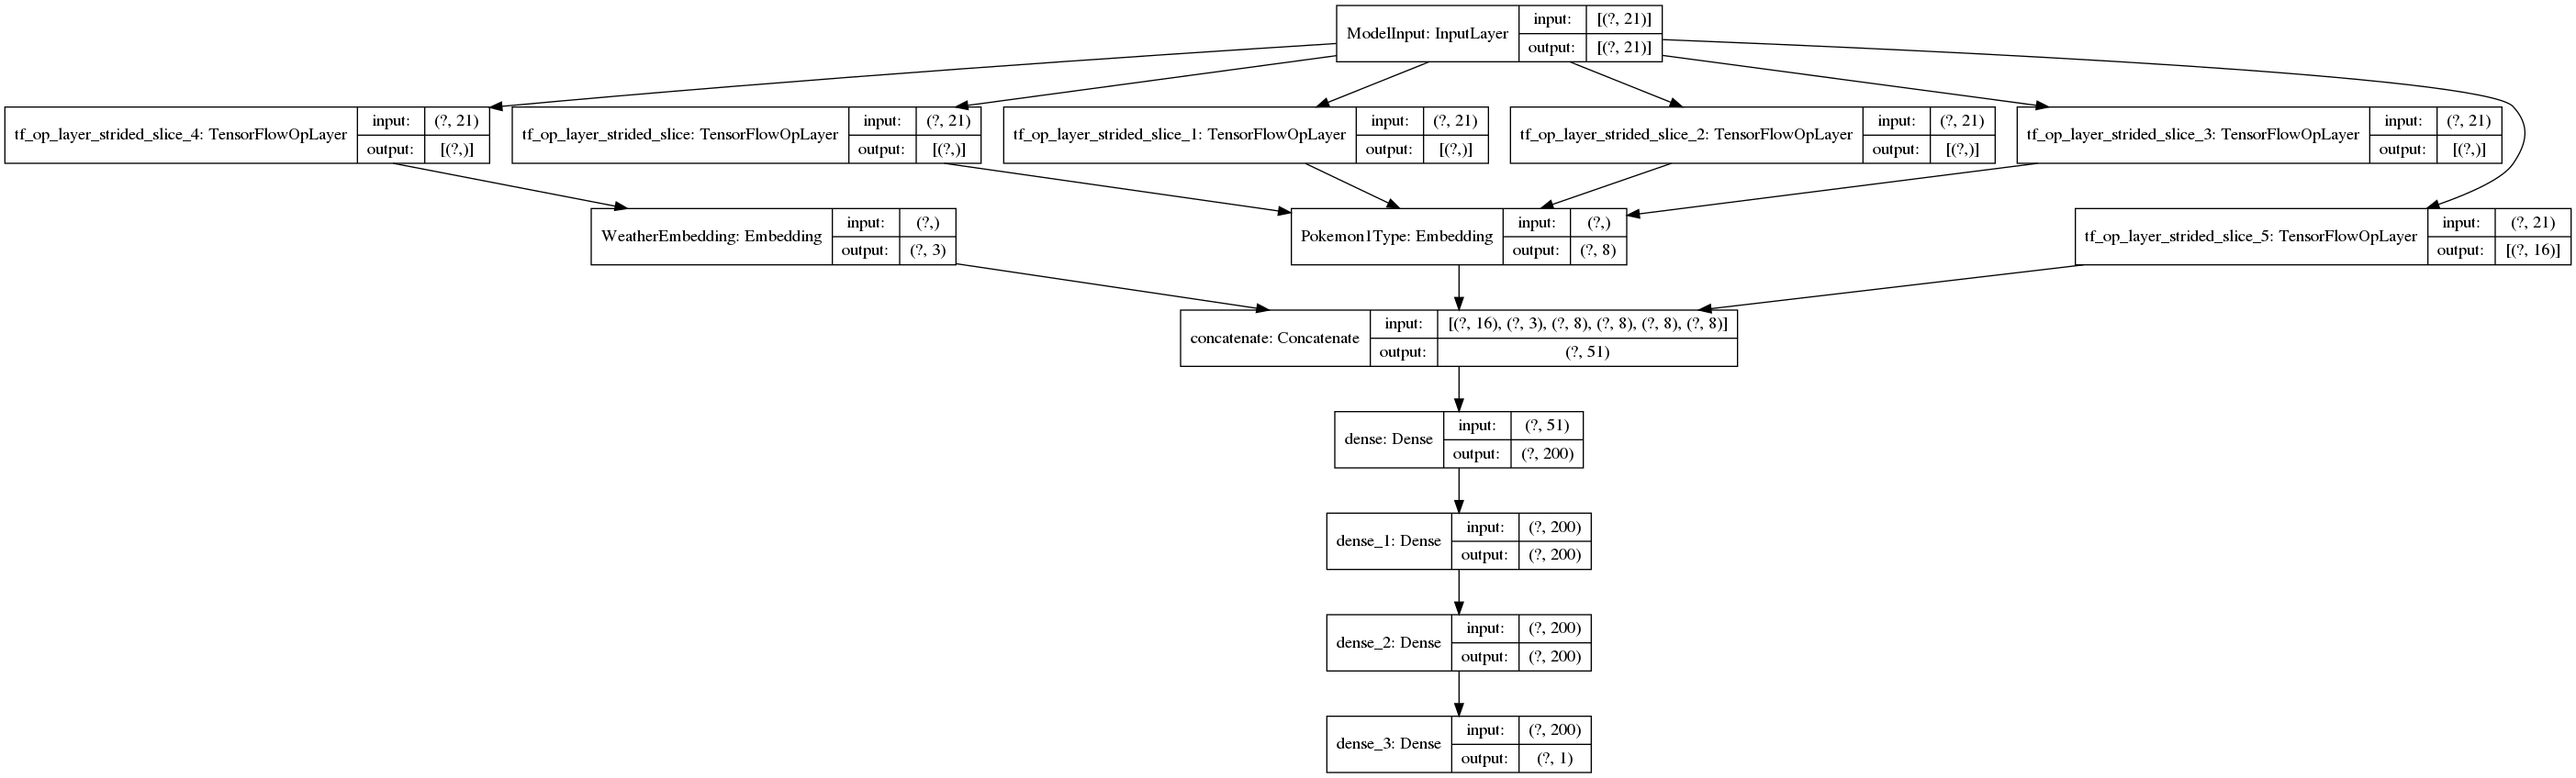

In [13]:
# Functional Model Architecture
""" Input columns are as follows:
- input[0:16] are numerical attributes
- input[16] is Ordinal WeatherAndTime
- input[17] is Ordinal Pokemon_1 First Nature
- input[18] is Ordinal Pokemon_1 Second Nature
- input[19] is Ordinal Pokemon_2 First Nature
- input[20] is Ordinal Pokemon_2 Second Nature
"""
model_input = layers.Input(shape=(21,), name='ModelInput')
type_emb = layers.Embedding(input_dim=18, output_dim=8, name="Pokemon1Type")
type1_emb_1 = type_emb(model_input[:,17])
type2_emb_1 = type_emb(model_input[:,18])
type1_emb_2 = type_emb(model_input[:,19])
type2_emb_2 = type_emb(model_input[:,20])
weather_emb = layers.Embedding(input_dim=5, output_dim=3, name="WeatherEmbedding")(model_input[:, 16])
x = layers.Concatenate()([model_input[:, 0:16], weather_emb, type1_emb_1, type2_emb_1, type1_emb_2, type2_emb_2])
x = layers.Dense(200, activation='relu')(x)
x = layers.Dense(200, activation='relu')(x)
x = layers.Dense(200, activation='relu')(x)
model_output = layers.Dense(1, activation='tanh')(x)

model = keras.Model(inputs=model_input, outputs=model_output)
plot_model(model, show_shapes=True)

- With Level and and Legendary 0.12

In [14]:
model.compile(loss='mse',
              optimizer=keras.optimizers.RMSprop(learning_rate=3e-3),
              metrics=['RootMeanSquaredError'])

### Train

In [15]:
history = model.fit(x_train_augm, y_train_augm, epochs=15,
                    validation_data=(x_val, y_val),
                    batch_size=1024)

Epoch 1/15
4249/4249 [==============================] - 22s 5ms/step - loss: 0.0227 - root_mean_squared_error: 0.1507 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1041
Epoch 2/15
4249/4249 [==============================] - 24s 6ms/step - loss: 0.0102 - root_mean_squared_error: 0.1009 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1047
Epoch 3/15
4249/4249 [==============================] - 24s 6ms/step - loss: 0.0084 - root_mean_squared_error: 0.0916 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0892
Epoch 4/15
4249/4249 [==============================] - 24s 6ms/step - loss: 0.0075 - root_mean_squared_error: 0.0867 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0827
Epoch 5/15
4249/4249 [==============================] - 23s 5ms/step - loss: 0.0071 - root_mean_squared_error: 0.0841 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0834
Epoch 6/15
4249/4249 [==============================] - 22s 5ms/step - loss: 0.0068 - root_mean_squared_error: 0.0822 - val_l

### Save Model

In [17]:
model.save('../data/03_models/nn_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../data/03_models/nn_model/assets


### Generate Output

In [23]:
def create_inference_data():
    """Return Same Format as Battle Results with additional PokemonID column"""
    # Repeat every row 6 times
    merged = pd.DataFrame(np.repeat(AvailablePokemons.values,6,axis=0), columns=AvailablePokemons.columns)
    # Drop PokemonID from Submission
    Submission_dropped = Submission.drop(columns=['SelectedPokemonID'])
    # Concat with Submission
    merged = merged.apply(lambda row: pd.concat([row, Submission_dropped.iloc[row.name%6]]), axis=1)
    return merged

inference_data = create_inference_data()

In [36]:
x_inference = full_pipeline.transform(inference_data)
inference_predictions = model.predict(x_inference)

/home/joel/.local/share/virtualenvs/pokethon-gj-dbL-j/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


In [45]:
def export(predictions):
    predictions = predictions.reshape(-1)
    table = np.empty((len(AvailablePokemons), 7))
    for i in range(len(AvailablePokemons)):
        table[i, 0] = i+1
        table[i, 1:] = predictions[i*6: (i+1)*6]
    df = pd.DataFrame(data=table, columns=['SelectedPokemonID']+list(Submission.Name_2.values))
    return df.astype({'SelectedPokemonID': int})
    
output = export(inference_predictions)
output

,SelectedPokemonID,Caterpie,Golem,Krabby,Mewtwo,Raichu,Venusaur
0,1,-0.588018,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1,2,0.719486,-0.933258,-1.000000,-1.000000,-1.000000,-0.993895
2,3,0.992590,-0.909129,-0.916925,-1.000000,-1.000000,-0.569005
3,4,0.999998,-0.877536,-0.857534,-1.000000,-0.999309,-0.165342
4,5,0.999999,-0.871356,-0.849662,-1.000000,-0.997947,-0.046473
...,...,...,...,...,...,...,...
1435,1436,1.000000,-0.835811,-0.258335,-1.000000,-0.999735,1.000000
1436,1437,1.000000,-0.716309,0.261378,-0.999998,-0.096369,1.000000
1437,1438,1.000000,-0.597677,0.453659,-0.999926,0.184544,1.000000
1438,1439,1.000000,-0.586558,0.469661,-0.999925,0.222535,1.000000


In [47]:
output.to_csv(path_or_buf='../data/04_model_output/nn_model/inference.csv')